In [1]:
from ngon import gen_polygon
from ngon import make_heatmap
from ngon import ngon_dual
from itertools import permutations
from itertools import combinations
import numpy as np

def random_on_sphere(n, d):
    pts = []
    for _ in range(n):
        x = np.random.rand(d) 
        x /= np.linalg.norm(x)
        pts.append(x)
    return np.array(pts)

def cluster_mixture(n, cln):
    d = cln + 3
    clus_cent = np.zeros([cln, d])
    for i in range(cln):
        clus_cent[i][i] = 10
    pts = []
    for i in range(n):
        x = np.random.rand(d) 
        x /= np.linalg.norm(x)
        index = i / (int(n) / int(cln))
        pts.append(x + clus_cent[int(index)])
    return np.array(pts)  
    

In [3]:
n = 20
d = 4
cln = 3
lam = 4
# pts = gen_polygon(n, n / (2 * np.pi))
# pts = random_on_sphere(n, d)
pts = cluster_mixture(n, cln)
alpha, beta, d = ngon_dual(n, pts, lam)
backup_alpha = alpha.copy()
backup_beta = beta.copy()
backup_d = d.copy()

/home/lorenzo/Documents/curis-2023-k-means/k-means/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/lorenzo/Documents/curis-2023-k-means/k-means/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [4]:
alpha = backup_alpha.copy()
beta = backup_beta.copy()
d = backup_d.copy()

# defines a class to conveniently manipulate delta, without caring about its epresentation.
class Delta:
    def __init__(self, d):
        self.d = d
    
    def set_val(self, k, i, j, val):
        i, j = sorted([i, j])
        self.d[k][i][j] = val
    
    def get_val(self, k, i, j):
        i, j = sorted([i, j])
        return d[k][i][j]

delta = Delta(d)

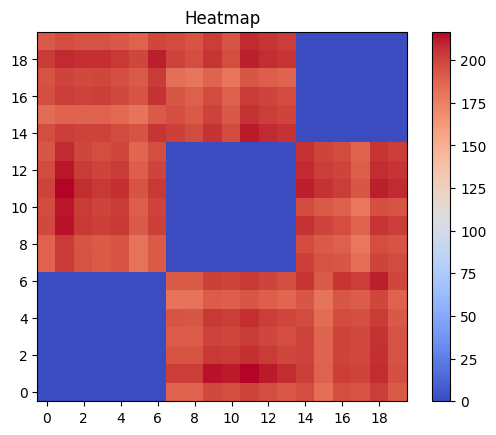

In [7]:
# generate a polygon with diamter ensuring side length ~ 1
constr = np.empty([n, n])
for i in range(n):
    for j in range(n):
        constr[i, j] = np.linalg.norm(pts[i] - pts[j]) ** 2

slack = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        if j == i:
            continue
        lhs = 2 * alpha + sum(d[k][max(i, j)][min(i, j)] for k in range(n))
        lhs -= sum(d[i][j][k] for k in range(n))
        lhs -= sum(d[j][k][i] for k in range(n))
        slack[i, j] = constr[i, j] - lhs

for i in range(n):
    for j in range(n):
        if slack[i][j] < 0.001:
            slack[i][j] = 0

make_heatmap(n, slack)

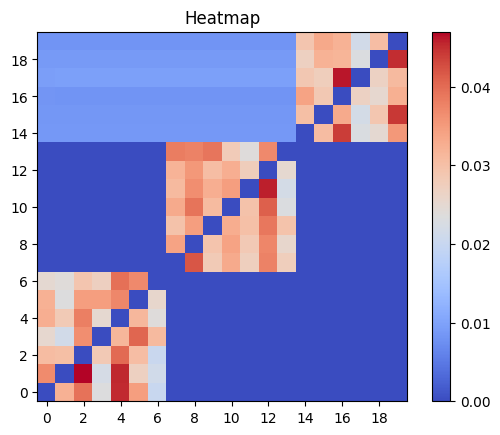

In [6]:
# clean varibles setting very small values to 0.           
for i in range(n):
    for j in range(n):
        if beta[i][j] < 0.001:
            beta[i][j] = 0
make_heatmap(n, beta)

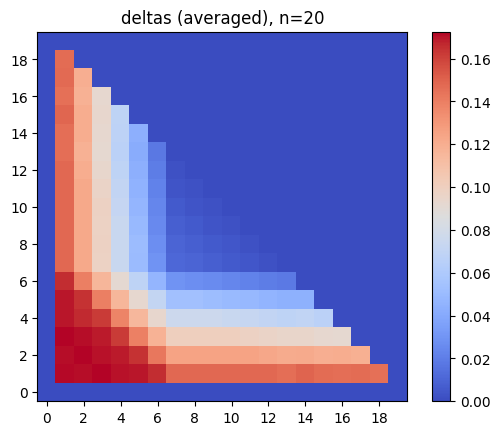

In [58]:
dd = np.zeros((n, n))
for i in range(1, n - 1):
    for j in range(1, n - i):
        total = 0
        for k in range(n):
            k1, k2 = sorted([(k+i) % n, (k-j) % n])
            total += d[k][k1][k2]
        dd[i][j] = total
make_heatmap(n, dd / n, title=f'deltas (averaged), n={n}')

In [205]:
# cleaning the variables is completely ineffective on the nagon example, beacuse we never have two positive deltas
# on the same {i, j, k}. Moreover, all betas are == 0. 

def two_deltas(delta, beta, k, i, j):
    success = False
    for a, b, c in permutations([k, i, j]):
        if delta.get_val(a, b, c) > 0.001 and delta.get_val(b, a, c) > 0.001:
            mn = min(delta.get_val(a, b, c), delta.get_val(b, a, c))
            beta[a, b] += mn
            beta[b, a] += mn
            delta.set_val(a, b, c, 0) 
            delta.set_val(b, a, c, delta.get_val(b, a, c) - mn)
            
            success = True
    return success

# prevents positive delta edges from being colocated with a positive betas
def delta_beta(delta, beta, k, i, j):
    success = False
    for a, b, c in permutations([k, i, j]):
        if delta.get_val(a, b, c) > 0.001 and beta[b, c] > 0.001:
            
            if beta[b, c] < delta.get_val(a, b, c):
                old_beta = beta[b, c] 
                new_delta = delta.get_val(a, b, c) - old_beta
                
                delta.set_val(a, b, c, new_delta)
                beta[b, c] = 0
                beta[b, a] += old_beta
                beta[a, c] += old_beta
            
            else:
                old_delta = delta.get_val(a, b, c)
                
                beta[b, c] -= old_delta
                beta[b, a] += old_delta
                beta[a, c] += old_delta
                delta.set_val(a, b, c, 0)
            
            success = True
    return success

def slackness(delta, beta, constr, alpha, i, j):
    lhs = 2 * alpha
    lhs -= beta[i, j] + beta[j, i]
    lhs += sum(delta.get_val(k, i, j) for k in range(n))
    lhs -= sum(delta.get_val(i, j, k) for k in range(n))
    lhs -= sum(delta.get_val(j, i, k) for k in range(n))
    
    if constr[i, j] - lhs > 0.001:
        return constr[i, j] - lhs
    else:
        return 0

def slack_delta(delta, beta, constr, alpha, k, i, j):
    success = False
    for a, b, c in permutations([k, i, j]):
        if delta.get_val(a, b, c) > 0.001:
#             print("a, b, c")
#             print(a, b, c)
            slc = slackness(delta, beta, constr, alpha, a, b)
#             print("slc")
#             print(slc)
            if slc > 0.001:
                print("success")
                new_delta = delta.get_val(a, b, c) - slc 
                delta.set_val(a, b, c, new_delta)
                beta[a, c] += slc
                success = True      
    return success

def rectify_variables(delta, beta):
    success = True
    
    while success:
        success = False
        for i, j, k in combinations(range(n), 3):
            tds = two_deltas(delta, beta, i, j, k) 
            dbs = delta_beta(delta, beta, i, j, k)
            sds = slack_delta(delta, beta, constr, alpha, i, j, k)
            success = success or tds or dbs or sds
            

rectify_variables(delta, beta)